In [20]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import os
import torch.cuda
import albumentations as albu
import segmentation_models_pytorch as smp
from  segmentation_models_pytorch.utils.base import Metric
from segmentation_models_pytorch.base.modules import Activation
from collections import defaultdict

In [21]:
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [22]:
def load_data(path):
    
    all_images=os.listdir(path/'images')
    all_masks=os.listdir(path/'masks')
    
    data = {'images':[],
           'masks':[]}
    for i in range(len(all_images)):
        data['images'].append(str(path/'images'/all_images[i]))
        data['masks'].append(str(path/'masks'/all_masks[i]))
    return pd.DataFrame(data)
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))

    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
        

In [23]:
DATASET_2D_BASE_PATH=Path(r'C:\Users\lm3088\Documents\POM-CTproject\Muhammad\Axials Version')
WIDTH=320
HEIGHT=320

In [24]:
df_train=load_data(DATASET_2D_BASE_PATH/'train')
df_val=load_data(DATASET_2D_BASE_PATH/'val')
df_train

,images,masks
0,C:\Users\lm3088\Documents\POM-CTproject\Muhamm...,C:\Users\lm3088\Documents\POM-CTproject\Muhamm...
1,C:\Users\lm3088\Documents\POM-CTproject\Muhamm...,C:\Users\lm3088\Documents\POM-CTproject\Muhamm...
2,C:\Users\lm3088\Documents\POM-CTproject\Muhamm...,C:\Users\lm3088\Documents\POM-CTproject\Muhamm...
3,C:\Users\lm3088\Documents\POM-CTproject\Muhamm...,C:\Users\lm3088\Documents\POM-CTproject\Muhamm...
4,C:\Users\lm3088\Documents\POM-CTproject\Muhamm...,C:\Users\lm3088\Documents\POM-CTproject\Muhamm...
...,...,...
20588,C:\Users\lm3088\Documents\POM-CTproject\Muhamm...,C:\Users\lm3088\Documents\POM-CTproject\Muhamm...
20589,C:\Users\lm3088\Documents\POM-CTproject\Muhamm...,C:\Users\lm3088\Documents\POM-CTproject\Muhamm...
20590,C:\Users\lm3088\Documents\POM-CTproject\Muhamm...,C:\Users\lm3088\Documents\POM-CTproject\Muhamm...
20591,C:\Users\lm3088\Documents\POM-CTproject\Muhamm...,C:\Users\lm3088\Documents\POM-CTproject\Muhamm...


In [25]:

class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_path, 
            masks_path, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.images = images_path
        self.masks = masks_path
        
    def __getitem__(self, i):
#         print(self.images[i])
        image = cv2.imread(str(self.images[i]))
        mask = cv2.imread(self.masks[i],0)
        mask=np.expand_dims(mask,axis=-1)
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
    def __len__(self):
        return len(self.images)

In [26]:
def get_training_augmentation():
    train_transform = [

   
        albu.Resize(HEIGHT,WIDTH),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.2,p=1, border_mode=cv2.BORDER_CONSTANT),
        albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.Blur(blur_limit=3, p=0.4),
        albu.GaussNoise(p=0.5),
        albu.RandomBrightnessContrast(brightness_limit=0.3,contrast_limit=0.3,p=0.5),
        albu.RandomBrightness(p=0.75)

    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
  
    test_transform = [
        albu.Resize(HEIGHT,WIDTH)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):  
    return x.transpose(2, 0, 1).astype('float32')



def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [27]:
ENCODER = 'efficientnet-b4' #'se_resnext50_32x4d' 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'
TRAIN_RUNS_PATH=r'C:\Users\lm3088\Documents\GitHub\MicroCTsegmentation\runs'
MODEL_NAME='Unet'
BATCH_SIZE=32
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to C:\Users\lm3088/.cache\torch\hub\checkpoints\efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

In [28]:
WEIGHTS_PATH=os.path.join(TRAIN_RUNS_PATH,f'{MODEL_NAME}_{ENCODER}')
WEIGHTS_PATH

'C:\\Users\\lm3088\\Documents\\GitHub\\MicroCTsegmentation\\runs\\Unet_efficientnet-b4'

In [29]:
summary(model, input_size=(3,320,320), batch_size=BATCH_SIZE, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [32, 3, 321, 321]               0
Conv2dStaticSamePadding-2         [32, 48, 160, 160]           1,296
       BatchNorm2d-3         [32, 48, 160, 160]              96
MemoryEfficientSwish-4         [32, 48, 160, 160]               0
         ZeroPad2d-5         [32, 48, 162, 162]               0
Conv2dStaticSamePadding-6         [32, 48, 160, 160]             432
       BatchNorm2d-7         [32, 48, 160, 160]              96
MemoryEfficientSwish-8         [32, 48, 160, 160]               0
          Identity-9             [32, 48, 1, 1]               0
Conv2dStaticSamePadding-10             [32, 12, 1, 1]             588
MemoryEfficientSwish-11             [32, 12, 1, 1]               0
         Identity-12             [32, 12, 1, 1]               0
Conv2dStaticSamePadding-13             [32, 48, 1, 1]             624
         I

C:\Users\lm3088\Anaconda3\envs\venv\lib\site-packages\torchsummary\torchsummary.py:93: RuntimeWarning: overflow encountered in long_scalars
  total_output += np.prod(summary[layer]["output_shape"])


In [30]:
class DCS(Metric):
    __name__ = 'DCS'

    def __init__(self, eps=0.00001, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
     
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        dice_numerator = 2 * torch.sum(y_pr * y_gt) + self.eps
        dice_denominator = torch.sum(y_pr) + torch.sum(y_gt) + self.eps
        dice_coefficient = dice_numerator / dice_denominator
        return dice_coefficient


In [31]:
train_dataset = Dataset(
    df_train['images'], 
    df_train['masks'], 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

valid_dataset = Dataset(
    df_val['images'], 
    df_val['masks'], 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
) 




C:\Users\lm3088\Anaconda3\envs\venv\lib\site-packages\albumentations\augmentations\transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [32]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    DCS()
    
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [33]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [34]:
# train model for 125 epochs
EPOCHS=125
if os.path.exists(WEIGHTS_PATH)==False:
    os.mkdir(WEIGHTS_PATH)
else:
    print(f"Warning! Directory {WEIGHTS_PATH } already exists")

In [35]:
min_loss = 100000000
train_history=defaultdict(list)
valid_history=defaultdict(list)

for i in range(0, EPOCHS):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if min_loss > valid_logs['dice_loss']:
        min_loss = valid_logs['dice_loss']
        torch.save(model, os.path.join(WEIGHTS_PATH,f'best_{str(i)}_{round(min_loss,4)}.pt'))
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')
    # Maintain History
    for log_key in train_logs.keys():
        train_history[log_key].append(train_logs[log_key])
        valid_history[log_key].append(valid_logs[log_key])


Epoch: 0
valid: 100%|█████████████████| 5192/5192 [03:19<00:00, 26.05it/s, dice_loss - 0.4701, iou_score - 0.8377, DCS - 0.5188]
Model saved!

Epoch: 1
valid: 100%|█████████████████| 5192/5192 [03:16<00:00, 26.37it/s, dice_loss - 0.3649, iou_score - 0.8623, DCS - 0.5424]
Model saved!

Epoch: 2
valid: 100%|█████████████████| 5192/5192 [03:11<00:00, 27.09it/s, dice_loss - 0.2536, iou_score - 0.8682, DCS - 0.5429]
Model saved!

Epoch: 3
valid: 100%|██████████████████| 5192/5192 [03:13<00:00, 26.86it/s, dice_loss - 0.1687, iou_score - 0.857, DCS - 0.5478]
Model saved!

Epoch: 4
valid: 100%|█████████████████| 5192/5192 [03:12<00:00, 27.00it/s, dice_loss - 0.1183, iou_score - 0.8682, DCS - 0.5439]
Model saved!

Epoch: 5
valid: 100%|█████████████████| 5192/5192 [03:14<00:00, 26.64it/s, dice_loss - 0.1024, iou_score - 0.8686, DCS - 0.5546]
Model saved!

Epoch: 6
valid: 100%|██████████████████| 5192/5192 [03:12<00:00, 27.02it/s, dice_loss - 0.106, iou_score - 0.8692, DCS - 0.5575]

Epoch: 7
va

valid: 100%|████████████████| 5192/5192 [03:07<00:00, 27.70it/s, dice_loss - 0.07823, iou_score - 0.8796, DCS - 0.6915]

Epoch: 65
valid: 100%|████████████████| 5192/5192 [03:06<00:00, 27.81it/s, dice_loss - 0.07776, iou_score - 0.8803, DCS - 0.7065]

Epoch: 66
valid: 100%|█████████████████| 5192/5192 [03:06<00:00, 27.78it/s, dice_loss - 0.0759, iou_score - 0.8821, DCS - 0.6956]
Model saved!

Epoch: 67
valid: 100%|████████████████| 5192/5192 [03:07<00:00, 27.72it/s, dice_loss - 0.07667, iou_score - 0.8814, DCS - 0.6679]

Epoch: 68
valid: 100%|████████████████| 5192/5192 [03:07<00:00, 27.75it/s, dice_loss - 0.07724, iou_score - 0.8805, DCS - 0.6561]

Epoch: 69
valid: 100%|████████████████| 5192/5192 [03:07<00:00, 27.71it/s, dice_loss - 0.07944, iou_score - 0.8788, DCS - 0.6534]

Epoch: 70
valid: 100%|████████████████| 5192/5192 [03:06<00:00, 27.77it/s, dice_loss - 0.07829, iou_score - 0.8796, DCS - 0.6831]

Epoch: 71
valid: 100%|█████████████████| 5192/5192 [03:07<00:00, 27.74it/s, dice

Text(0, 0.5, 'dice_loss')

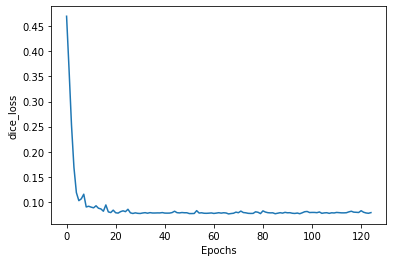

In [36]:
plt.plot(valid_history['dice_loss'])
plt.xlabel("Epochs")
plt.ylabel("dice_loss")

In [37]:
pd.DataFrame(valid_history).to_csv(os.path.join(WEIGHTS_PATH,'validation_logs.csv'))
pd.DataFrame(train_history).to_csv(os.path.join(WEIGHTS_PATH,'train_logs.csv'))